# import package

In [0]:
''' basic package '''
import numpy as np
from pprint import pprint
''' tensorflow package '''
import tensorflow as tf
#import mnist dataset
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib import rnn

# Config 

In [0]:
mnist = input_data.read_data_sets("../RNN/tmp/data/", one_hot=True)
#define constants
#unrolled through 28 time steps
time_steps=28
#hidden LSTM units
hidden_layer_size=128
#LSTM layers
number_of_layers=1
#Drop
dropout=True
#Drop rate
dropout_rate=0.8
#rows of 28*2 pixels
n_input=28*2
#learning rate for adam
learning_rate=0.001
#mnist is meant to be classified in 10 classes(0-9).
n_classes=10
#size of batch
batch_size=128

Extracting ../RNN/tmp/data/train-images-idx3-ubyte.gz
Extracting ../RNN/tmp/data/train-labels-idx1-ubyte.gz
Extracting ../RNN/tmp/data/t10k-images-idx3-ubyte.gz
Extracting ../RNN/tmp/data/t10k-labels-idx1-ubyte.gz


# Train 

In [0]:
import matplotlib.pyplot as plt

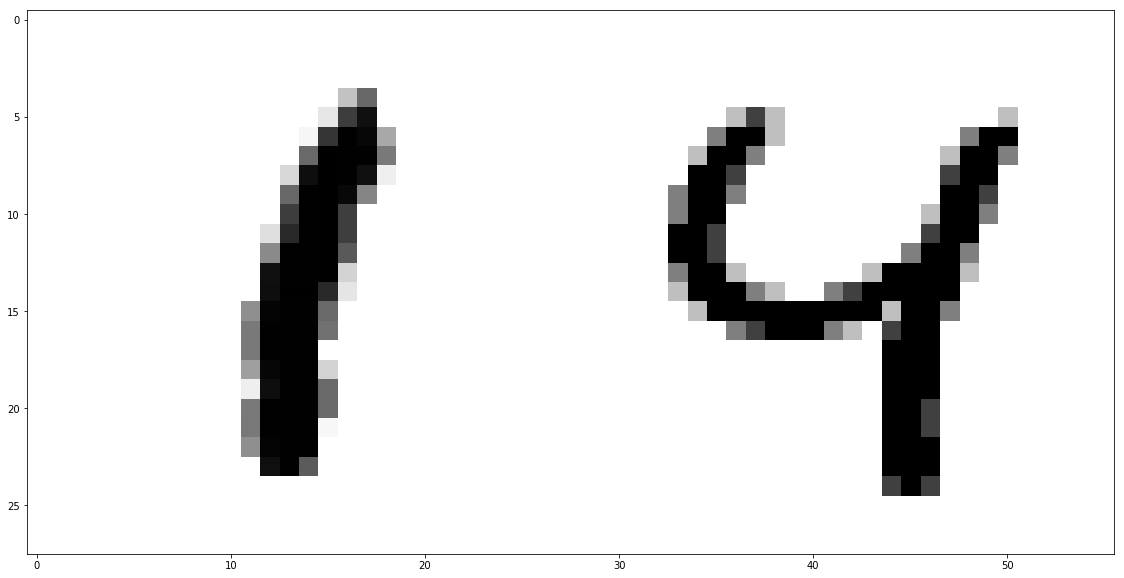

In [0]:
x1, _ = mnist.train.next_batch(batch_size=batch_size)
x2, _ = mnist.train.next_batch(batch_size=batch_size)

x1 = x1.reshape((128,28,28))
x2 = x2.reshape((128,28,28))
batch_x = np.concatenate((x1,x2),axis=2)  

plt.figure(figsize=(20,10))
plt.imshow(batch_x[0],cmap='binary')

In [0]:
###Output layer###
#weights and biases of appropriate shape to accomplish above task
#converting last output of dimension [batch_size,num_units] to [batch_size,n_classes] by out_weight multiplication
def output_layer(LSTM_outputs, n_classes):
    LSTM_outputs = LSTM_outputs[:,-1,:]
    prediction = tf.layers.dense(inputs= LSTM_outputs, units= n_classes)          
    return prediction

###LSTM layer###
def LSTM_cell(hidden_layer_size, X, number_of_layers, dropout=True, dropout_rate=0.8):
    def get_LSTM(hidden_layer_size, dropout, dropout_rate):
        layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)

        if dropout:
            layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
            
        return layer
    
    cell = tf.contrib.rnn.MultiRNNCell([get_LSTM(hidden_layer_size, dropout, dropout_rate) for _ in range(number_of_layers)])
    init_state = cell.zero_state(tf.shape(X)[0], tf.float32)

    return cell, init_state     

### Tensorflow- 建立靜態圖 

**靜態圖**就像一張計畫圖一樣，定義我們的計算流程。實際運算必須靠 **<span style="color:red;"> Session </span>** 來執行


In [0]:
import tensorflow as tf

In [0]:
main_graph = tf.Graph()
sess = tf.Session(graph=main_graph)

with main_graph.as_default():
    
    ##defining placeholders##
    #input image placeholder
    #input label placeholder
    with tf.name_scope("inputs"):
        X=tf.placeholder(tf.float32,[None,time_steps,n_input], name='X')
        y1=tf.placeholder(tf.float64,[None,n_classes], name='y1')
        y2=tf.placeholder(tf.float64,[None,n_classes], name='y2')
    
    ##LSTM layer##
    with tf.variable_scope("LSTM_layer"):
        cell, init_state = LSTM_cell(hidden_layer_size, X, number_of_layers, dropout, dropout_rate) 
        outputs, states = tf.nn.dynamic_rnn(cell, X, initial_state=init_state)  
        
    
    ##output layer##
    with tf.variable_scope("output1_layer"):
        prediction1 = output_layer(outputs, n_classes)
    with tf.variable_scope("output2_layer"):
        prediction2 = output_layer(outputs, n_classes)        

    
    ##loss_function##
    with tf.name_scope("loss"):
        loss1=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction1,labels=y1))
        loss2=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction2,labels=y2))
        loss = loss1 + loss2
    ##optimization##
    with tf.name_scope("optimizer"):
        opt=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    ##model evaluation##
    with tf.name_scope("accuracy"):
        correct_prediction=tf.logical_and(tf.equal(tf.argmax(prediction1,1),tf.argmax(y1,1)), tf.equal(tf.argmax(prediction2,1),tf.argmax(y2,1)))
        accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))    

    init = tf.global_variables_initializer()
    

### Tensorflow- 初始化模型

In [0]:
#### initialize model ####
sess.run(init)

### Tensorflow- 實際執行模型訓練

In [0]:
iter=1
while iter<5000:
    x1,batch_y1=mnist.train.next_batch(batch_size=batch_size)
    x2,batch_y2=mnist.train.next_batch(batch_size=batch_size)
    x1=x1.reshape((128,28,28))
    x2=x2.reshape((128,28,28))
    batch_x = np.concatenate((x1,x2),axis=2)    

    sess.run(opt, feed_dict={X: batch_x, y1: batch_y1, y2:batch_y2})

    if iter %200==0:
        acc=sess.run(accuracy,feed_dict={X: batch_x, y1: batch_y1, y2:batch_y2})
        los=sess.run(loss,feed_dict={X: batch_x, y1: batch_y1, y2:batch_y2})
        print("For iter ",iter)
        print("Accuracy ",acc)
        print("Loss ",los)
        print("__________________")

    iter=iter+1
        
los=sess.run(loss,feed_dict={X: batch_x, y1: batch_y1, y2:batch_y2})
acc=sess.run(accuracy,feed_dict={X: batch_x, y1: batch_y1, y2:batch_y2})
print(acc)

For iter  200
Accuracy  0.578125
Loss  1.49232
__________________
For iter  400
Accuracy  0.710938
Loss  0.910898
__________________
For iter  600
Accuracy  0.890625
Loss  0.46934
__________________
For iter  800
Accuracy  0.859375
Loss  0.531781
__________________
For iter  1000
Accuracy  0.882812
Loss  0.462525
__________________
For iter  1200
Accuracy  0.882812
Loss  0.392423
__________________
For iter  1400
Accuracy  0.898438
Loss  0.293724
__________________
For iter  1600
Accuracy  0.9375
Loss  0.263412
__________________
For iter  1800
Accuracy  0.929688
Loss  0.16547
__________________
For iter  2000
Accuracy  0.953125
Loss  0.243923
__________________
For iter  2200
Accuracy  0.945312
Loss  0.208802
__________________
For iter  2400
Accuracy  0.945312
Loss  0.191697
__________________
For iter  2600
Accuracy  0.96875
Loss  0.185827
__________________
For iter  2800
Accuracy  0.96875
Loss  0.172162
__________________
For iter  3000
Accuracy  0.945312
Loss  0.18273
___________

In [0]:
#calculating test accuracy
x1 = mnist.test.images[:128].reshape((-1, time_steps, 28))
x2 = mnist.test.images[128:256].reshape((-1, time_steps, 28))
test_data = np.concatenate((x1,x2),axis=2)
# test_label = mnist.test.labels[:128]
test_y1 = mnist.test.labels[:128]
test_y2 = mnist.test.labels[128:256]
print("Testing Accuracy:", sess.run(accuracy, feed_dict={X: test_data, y1: test_y1, y2:test_y2}))    

Testing Accuracy: 0.976562


In [0]:
sess.close()